In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,RocCurveDisplay,PrecisionRecallDisplay,average_precision_score,precision_score,matthews_corrcoef,accuracy_score,recall_score,f1_score
import matplotlib.pyplot as plt

In [2]:
othermet=pd.read_csv("./src/other_methods_scores.csv.zip",index_col=0,
                    compression="zip")

In [5]:
PSPhunter= pd.read_excel("./src/PSPHunter_Supplementary_Table_2.xlsx.zip",skiprows=1, decimal=',',
                        compression="zip")

PSPhunter=PSPhunter.set_index("Uniprot")

In [7]:
othermet["PSPHunter"]=np.nan
othermet.loc[list(set(othermet.index).intersection(PSPhunter.index)),"PSPHunter"]=PSPhunter.Probability

In [8]:
catG2_human_prot = pd.read_csv("./src/catG2_scores_human_proteome.csv.zip",index_col=0,
                              compression="zip")
othermet["catGRANULE2"]=np.nan
othermet.loc[list(set(othermet.index).intersection(catG2_human_prot.index)),"catGRANULE2"]=catG2_human_prot.LLPS_score

In [9]:
othermet=othermet.loc[:,["catGRANULE","MaGS","PICNIC","PICNICGO","PSPHunter","catGRANULE2"]]

# Performance on the test set

In [10]:
test_ids=pd.read_csv("./DATASETS/TestSet_IDs.csv",index_col=0)
inters=list(set(test_ids.index).intersection(othermet.index))

test_ids=test_ids.loc[inters]

In [11]:
tmpdf=othermet.loc[test_ids.index]
tmpdf=tmpdf.reindex(test_ids.index)
tmpdf["label"]=test_ids.labels

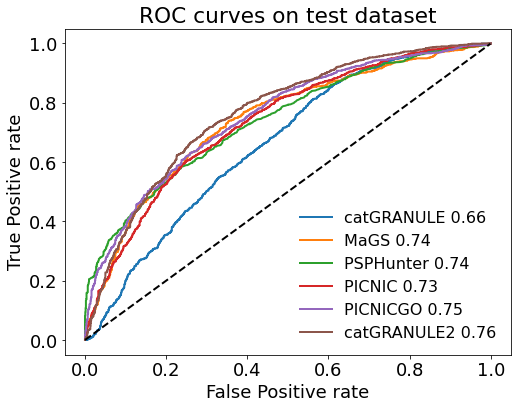

(None, None)

In [12]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})


fig,ax=plt.subplots(figsize=(8,6))
ax.set_title("ROC curves on test dataset")

for method in ["catGRANULE","MaGS","PSPHunter","PICNIC","PICNICGO","catGRANULE2"]:
    tmpdf2=tmpdf.dropna(subset=[method])
    RocCurveDisplay.from_predictions(tmpdf2['label'], tmpdf2[method],lw=2, ax=ax,label=method+" %.2f" % (roc_auc_score(tmpdf2['label'], tmpdf2[method])))

        # print('-'*80)
ax.plot(np.arange(0,1,.001),np.arange(0,1,.001),lw=2,linestyle='dashed',color='black')
ax.legend(loc=0,frameon=False,fontsize=16)
ax.set_xlabel("False Positive rate")
ax.set_ylabel("True Positive rate")
    # 
plt.savefig("ROC_curves.pdf",bbox_inches="tight")
plt.show(),plt.close()

In [14]:
from sklearn.preprocessing import binarize

data=[]
for (method,thr) in zip(["catGRANULE","MaGS","PSPHunter","PICNIC","PICNICGO","catGRANULE2"],[0.5,1.16,0.82,0.5,0.5,0.5]):
    tmpdf2=tmpdf.dropna(subset=[method])
    binn=binarize(tmpdf2[method].values.reshape(-1, 1),threshold=thr)
    AUROC=roc_auc_score(tmpdf2['label'], tmpdf2[method])
    data.append([method,"AUROC",AUROC])
    AUPRC=average_precision_score(tmpdf2['label'], tmpdf2[method])
    data.append([method,"AUPRC",AUPRC])
    acc=accuracy_score(tmpdf2['label'], binn)
    data.append([method,"Accuracy",acc])
    prec=precision_score(tmpdf2['label'], binn)
    rec=recall_score(tmpdf2['label'], binn)
    data.append([method,"Recall",rec])
    data.append([method,"Precision",prec])
    f1=f1_score(tmpdf2['label'], binn)
    data.append([method,"F1-score",f1])
    mcc=matthews_corrcoef(tmpdf2['label'], binn)
    data.append([method,"MCC",mcc])

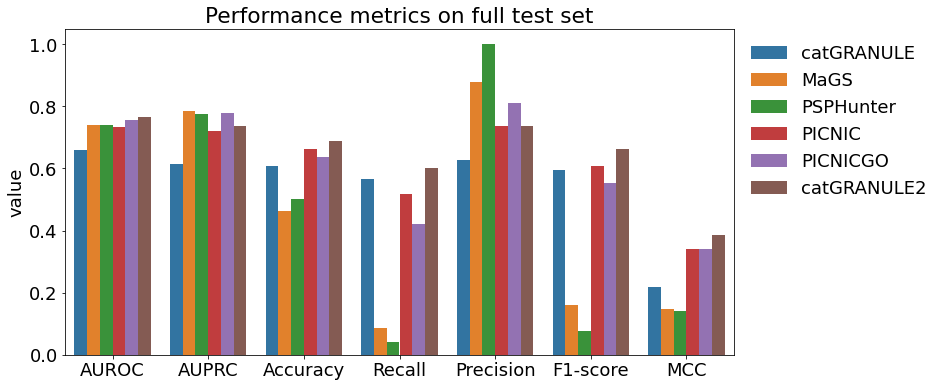

(None, None)

In [15]:
import seaborn as sns

df=pd.DataFrame(data=data)
df.columns=["Method","Metric","value"]
fig,ax=plt.subplots(figsize=(12,6))
sns.barplot(data=df,x="Metric",y="value",hue="Method",ax=ax)
    #ax.plot(np.arange(0,1,.001),np.arange(0,1,.001),linestyle='dashed',color='black')
ax.legend(bbox_to_anchor=(1,1),frameon=False)
ax.set_title("Performance metrics on full test set")
ax.set_xlabel("")
# ax.set_ylim(0.2,1)
    # 
plt.savefig("Perf_Metrics_TestSet.pdf",bbox_inches="tight")
plt.show(),plt.close()